<div style="nosxt-align:cennosr; font-size:26px; color:green;"> 2 ESTRATEGIA DE CRUCE DE  MEDIAS MOVILES EXPONENCIALES (EMA’s) </div>

Si no compartimos el conocimiento no sirve para nada. [Michio Kaku](https://www.younuestrobe.com/watch?v=6rDxlolYUQw)



**Descarga de cotizaciones.**  
Para obtener datos históricos de precios, puedes:

Descargarlos directamente desde las gestoras de los fondos.
Utilizar plataformas públicas como Yahoo Finance mediante la librería yfinance.
yfinance es una herramienta popular en análisis financiero que facilita el acceso a datos históricos considerados de dominio público. Sin embargo, estos datos pueden presentar pequeñas diferencias con respecto a las fuentes oficiales. Por ello, para decisiones críticas, siempre se recomienda contrastar la información con la documentación oficial de la gestora.

⚠️ **Precauciones.**
Este proyecto utiliza yfinance (con licencia bajo la [Apache License 2.0](https://www.apache.org/licenses/LICENSE-2.0).
), una interfaz para descargar datos financieros desde Yahoo Finance. Ten en cuenta lo siguiente:

Los datos descargados son exclusivamente para uso personal.
No está permitido redistribuirlos o venderlos.
Su uso en contextos educativos o sin ánimo de lucro suele ser aceptable, siempre que se cumplan estas condiciones.
Evita realizar peticiones excesivas o abusivas que puedan violar los términos de uso del servicio.

<a name='Gr%C3%A1fico-con-la-evoluci%C3%B3n-de-las-cotizaciones-del-IBEX-35.'></a>
# Importación de módulos

In [ ]:
import math
from math import floor
import pandas as pd
import yfinance as yf
import numpy as np
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px

plt.rcParams['figure.figsize'] = (8, 4)
plt.style.use('fivethirtyeight')


# Estrategia de cruce de Medias Móviles Exponenciales (EMA's)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from typing import Optional, Tuple, Dict, Any
import os
import yfinance as yf
import tkinter as tk
from tkinter import font

class ImportarCotizaciones:
    def __init__(self):
        self._data: Dict[str, pd.DataFrame] = {}
        self.all_value_closures: Optional[pd.DataFrame] = None
        self.value_closures: Optional[pd.DataFrame] = None
        self.all_benchmark_closures: Optional[pd.DataFrame] = None
        self.benchmark_close: Optional[pd.DataFrame] = None
        self.ticker: Optional[str] = None
        self.benchmark_ticker: Optional[str] = None
        self.start_date: Optional[str] = None
        self.end_date: Optional[str] = None
        self.directory_path: Optional[str] = None

    def solicitar_datos(self) -> Tuple[Optional[pd.DataFrame], Optional[pd.DataFrame], Optional[pd.DataFrame], Optional[pd.DataFrame]]:
        """Solicita los datos necesarios al usuario y devuelve los dataframes."""
        print("Selección del valor:")
        value_option = int(input("""
        ¿De dónde desea obtener el valor?
        1. Descargar de Yahoo Finance
        2. Importar de fichero CSV de Yahoo Finance
        3. Importar de fichero CSV de R4
        Seleccione una opción (1-3): """))

        if value_option == 1:
            self.ticker = self._get_input("Ingrese el ticker del valor: ")
            self.start_date = self._get_input("Ingrese la fecha de inicio (YYYY-MM-DD): ")
            self.end_date = self._get_input("Ingrese la fecha de fin (YYYY-MM-DD): ")
            self._fetch_data(self.ticker)
        elif value_option == 2:
            self.directory_path = self._get_input("Introduce la ruta para el valor (o presiona Enter para usar la misma): ", optional=True)
            if not self.directory_path:
                self.directory_path = os.getcwd()  # Usar el directorio actual si se presiona Enter
            value_archivo = self.listar_archivos()
            if value_archivo:
                self.ticker = os.path.splitext(value_archivo)[0]  # Usar el nombre del archivo como ticker (sin extensión)
                self.all_value_closures, self.value_closures = self.crear_data_frame_csv_yf(value_archivo)
                self._data[self.ticker] = self.all_value_closures
                self.start_date = str(self.all_value_closures.index.min().date()) if not self.all_value_closures.empty else None
                self.end_date = str(self.all_value_closures.index.max().date()) if not self.all_value_closures.empty else None
            else:
                print("No se seleccionó archivo para el valor.")
                return None, None, None, None
        elif value_option == 3:
            self.directory_path = self._get_input("Introduce la ruta para el valor (o presiona Enter para usar la misma): ", optional=True)
            if not self.directory_path:
                self.directory_path = os.getcwd()  # Usar el directorio actual si se presiona Enter
            value_archivo = self.listar_archivos()
            if value_archivo:
                self.ticker = os.path.splitext(value_archivo)[0]  # Usar el nombre del archivo como ticker (sin extensión)
                self.all_value_closures, self.value_closures = self.crear_data_frame_csv_r4(value_archivo)
                self._data[self.ticker] = self.all_value_closures
                self.start_date = str(self.all_value_closures.index.min().date()) if not self.all_value_closures.empty else None
                self.end_date = str(self.all_value_closures.index.max().date()) if not self.all_value_closures.empty else None
            else:
                print("No se seleccionó archivo para el valor.")
                return None, None, None, None
        else:
            print("Opción no válida para el valor.")
            return None, None, None, None

        # Preguntar por benchmark adicional
        quiere_benchmark = input("\n¿Desea añadir un benchmark? (s/n): ").lower()
        if quiere_benchmark == 's' or quiere_benchmark == 'si':
            self.solicitar_datos_benchmark()

        self.crear_data_frames()
        return self.all_value_closures, self.value_closures, self.all_benchmark_closures, self.benchmark_close

    def solicitar_datos_benchmark(self):
        """Solicita los datos del benchmark y los agrega al objeto."""
        print("\nSelección del benchmark adicional:")
        benchmark_option = int(input("""
        ¿De dónde desea obtener el benchmark?
        1. Descargar de Yahoo Finance
        2. Importar de fichero CSV de Yahoo Finance
        3. Importar de fichero CSV de R4
        Seleccione una opción (1-3): """))

        if benchmark_option == 1:
            self.benchmark_ticker = self._get_input("Ingrese el ticker del benchmark: ")
            if self.start_date and self.end_date:
                self._fetch_data(self.benchmark_ticker)
            else:
                print("Las fechas de inicio y fin del valor deben estar definidas primero.")
        elif benchmark_option == 2:
            benchmark_directory = self._get_input("Introduce la ruta para el benchmark (o presiona Enter para usar la misma): ", optional=True)
            if not benchmark_directory:
                benchmark_directory = self.directory_path

            self.directory_path = benchmark_directory
            benchmark_archivo = self.listar_archivos()

            if benchmark_archivo:
                self.benchmark_ticker = os.path.splitext(benchmark_archivo)[0]
                _, benchmark_close_data = self.crear_data_frame_csv_yf(benchmark_archivo)
                self._data[self.benchmark_ticker] = benchmark_close_data
            else:
                print("No se seleccionó archivo para el benchmark.")
        elif benchmark_option == 3:
            benchmark_directory = self._get_input("Introduce la ruta para el benchmark (o presiona Enter para usar la misma): ", optional=True)
            if not benchmark_directory:
                benchmark_directory = self.directory_path

            self.directory_path = benchmark_directory
            benchmark_archivo = self.listar_archivos()

            if benchmark_archivo:
                self.benchmark_ticker = os.path.splitext(benchmark_archivo)[0]
                _, benchmark_close_data = self.crear_data_frame_csv_r4(benchmark_archivo)
                self._data[self.benchmark_ticker] = benchmark_close_data
            else:
                print("No se seleccionó archivo para el benchmark.")
        else:
            print("Opción no válida para benchmark.")

    def _get_input(self, prompt: str, optional: bool = False) -> str:
        """Obtiene una entrada del usuario con validación."""
        while True:
            value = input(prompt).strip()
            if value or optional:
                return value
            print("Este campo es obligatorio. Por favor, ingréselo.")

    def _fetch_data(self, ticker: str) -> None:
        """Descarga datos históricos de precios para un ticker dado."""
        try:
            df = yf.download(ticker, start=self.start_date, end=self.end_date, auto_adjust=False, progress=False)
            df.index = pd.to_datetime(df.index)
            df.index.name = 'Date'
            self._data[ticker] = df
        except Exception as e:
            raise ValueError(f"No se pudieron descargar los datos para {ticker}: {e}")

    def format_date_index(self) -> None:
        """Formatea el índice de fechas de todos los DataFrames a 'YYYY-MM-DD'."""
        for df in self._data.values():
            if not df.empty:
                df.index = pd.to_datetime(df.index).strftime('%Y-%m-%d')
                df.index = pd.to_datetime(df.index)

    @property
    def combined_close_df(self) -> Optional[pd.DataFrame]:
        """Devuelve un DataFrame con los precios de cierre fusionados."""
        if not self._data or not self.ticker:
            return None

        df = self._data[self.ticker][['Close']].copy()
        df.columns = [f'Close_{self.ticker}']

        if self.benchmark_ticker and self.benchmark_ticker in self._data:
            benchmark_df = self._data[self.benchmark_ticker][['Close']]
            benchmark_df.columns = [f'Close_{self.benchmark_ticker}']
            df = pd.merge(df, benchmark_df, left_index=True, right_index=True)

        return df

    def crear_data_frames(self) -> None:
        """Crea y almacena los DataFrames necesarios."""
        if not self._data or not self.ticker:
            return

        self.format_date_index()

        # Seleccionar el nivel de etiqueta de columnas deseado para historical_closes
        for ticker in self._data.keys():
            if isinstance(self._data[ticker].columns, pd.MultiIndex):
                self._data[ticker].columns = self._data[ticker].columns.get_level_values('Price')

        self.all_value_closures = self._data[self.ticker]
        self.value_closures = self._data[self.ticker][['Close']]

        if self.benchmark_ticker and self.benchmark_ticker in self._data:
            self.all_benchmark_closures = self._data[self.benchmark_ticker]
            self.benchmark_close = self._data[self.benchmark_ticker][['Close']]
        else:
            self.all_benchmark_closures = None
            self.benchmark_close = None

    def get_historical_prices(self) -> Tuple[Dict[str, Any], Optional[pd.DataFrame], Optional[pd.DataFrame], Optional[pd.DataFrame], Optional[pd.DataFrame]]:
        """Obtiene y devuelve un diccionario con los datos y los DataFrames."""
        self.crear_data_frames()

        data_dict = {
            'ticker': self.ticker,
            'benchmark_ticker': self.benchmark_ticker,
            'start_date': self.start_date,
            'end_date': self.end_date,
            'all_value_closes': self.all_value_closures,
            'value_close': self.value_closures,
            'all_benchmark_closes': self.all_benchmark_closures,
            'benchmark_close': self.benchmark_close
        }

        return data_dict, self.all_value_closures, self.value_closures, self.all_benchmark_closures, self.benchmark_close

    def listar_archivos(self):
        """Lista los archivos CSV en el directorio y permite seleccionar uno."""
        files = [f for f in os.listdir(self.directory_path) if f.endswith('.csv')]
        print("Archivos CSV disponibles:")
        for i, file in enumerate(files):
            print(f"{i+1}. {file}")

        while True:
            try:
                choice = int(input("Selecciona un archivo (o 0 para salir): "))
                if choice == 0:
                    return None
                elif 1 <= choice <= len(files):
                    return files[choice-1]
                else:
                    print("Opción inválida. Intenta de nuevo.")
            except ValueError:
                print("Por favor, ingresa un número válido.")

    def crear_data_frame_csv_yf(self, file_name):
        """Crea un DataFrame a partir del archivo seleccionado de Yahoo Finance."""
        file_path = os.path.join(self.directory_path, file_name)
        df =  pd.read_csv(
            file_path,
            sep=",",  # Yahoo usa comas como separador
            parse_dates=True,
            index_col="Date"  # La columna de fecha en Yahoo se llama "Date"
        )
        # Convertir el índice a datetime y formatearlo
        df.index = pd.to_datetime(df.index)
        df.index.name = 'Date'
        df.index = pd.to_datetime(df.index).strftime('%Y-%m-%d')
        df.index = pd.to_datetime(df.index)

        # Crear copias de los DataFrames
        self.all_value_closures = df.copy()
        self.value_closures = self.all_value_closures[['Close']]

        # Devuelve los DataFrames
        return self.all_value_closures, self.value_closures

    def crear_data_frame_csv_r4(self, file_name):
        """Crea un DataFrame a partir del archivo seleccionado de R4."""
        file_path = os.path.join(self.directory_path, file_name)

        try:
            # Leer el archivo con separador de espacio en blanco y nombres de columna explícitos
            df = pd.read_csv(
                file_path,
                sep=r'\s+',  # Usar cualquier espacio en blanco como delimitador (r'\s+')
                names=['Date', 'Close'],  # Nombres explícitos de las columnas
                decimal=",",  # Usar la coma como separador decimal
                skiprows=1,  # Saltar la fila de encabezado
                engine='python' # Añadimos el motor de python para evitar un warning.
            )

            # Limpiar la comilla y convertir a datetime
            df['Date'] = df['Date'].str.replace("'", "")
            df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')  # Especificamos el formato y convertimos las fechas inválidas en NaT

        except KeyError as e:
            # Manejar columnas faltantes
            print(f"Error: Columnas faltantes en '{file_name}': {e}")
            print("Columnas esperadas: 'Date', 'Close'")
            return None  # O lanzar una excepción específica

        # Eliminar filas con fechas inválidas
        df = df.dropna(subset=['Date'])

        # Establecer la columna 'Date' como índice
        df.set_index('Date', inplace=True)

        # Crear copias de los DataFrames
        self.all_value_closures = df.copy()
        self.value_closures = self.all_value_closures[['Close']]

        # Devuelve los DataFrames
        return self.all_value_closures, self.value_closures

class EMAsStrategy:
    def __init__(self, all_value_closures, value_closures,all_benchmark_closures, benchmark_close,
                 ticker, benchmark_ticker,start_date, end_date, short_period, long_period, initial_capital, ventana_moda):
        """
        Inicializa la clase AnalisisCotizaciones con los datos de cotizaciones.

        Args:
            all_value_closures (Optional[pd.DataFrame]): DataFrame con todos los datos del valor.
            value_closures (Optional[pd.DataFrame]): DataFrame con solo los precios de cierre del valor.
            all_benchmark_closures (Optional[pd.DataFrame]): DataFrame con todos los datos del benchmark.
            benchmark_close (Optional[pd.DataFrame]): DataFrame con solo los precios de cierre del benchmark.
            ticker (Optional[str]): Ticker del valor.
            benchmark_ticker (Optional[str]): Ticker del benchmark.
            start_date (Optional[str]): Fecha de inicio del periodo analizado (YYYY-MM-DD).
            end_date (Optional[str]): Fecha de fin del periodo analizado (YYYY-MM-DD).
        """
        self.all_value_closures = all_value_closures
        self.value_closures = value_closures
        self.all_benchmark_closures = all_benchmark_closures
        self.benchmark_close = benchmark_close
        self.ticker = ticker
        self.benchmark_ticker = benchmark_ticker
        self.start_date = start_date
        self.end_date = end_date
        self.rendimientos_valor = self.calcular_rendimientos(self.value_closures)
        self.rendimientos_benchmark = self.calcular_rendimientos(self.benchmark_close)
        self.short_period = short_period
        self.long_period = long_period
        self.initial_capital = initial_capital
        self.ventana_moda = ventana_moda

    def calcular_rendimientos(self, dataframe: Optional[pd.DataFrame]) -> Optional[pd.Series]:
        """
        Calcula los rendimientos porcentuales de un DataFrame de precios de cierre.

        Args:
            dataframe (Optional[pd.DataFrame]): DataFrame con una columna de precios de cierre.

        Returns:
            Optional[pd.Series]: Serie con los rendimientos porcentuales, o None si el DataFrame es inválido.
        """
        if dataframe is not None and not dataframe.empty and 'Close' in dataframe.columns:
            return dataframe['Close'].pct_change().dropna()
        return None

    def obtener_rendimientos_valor(self) -> Optional[pd.Series]:
        """
        Obtiene los rendimientos del valor.

        Returns:
            Optional[pd.Series]: Serie con los rendimientos del valor.
        """
        return self.rendimientos_valor

    def obtener_rendimientos_benchmark(self) -> Optional[pd.Series]:
        """
        Obtiene los rendimientos del benchmark.

        Returns:
            Optional[pd.Series]: Serie con los rendimientos del benchmark.
        """
        return self.rendimientos_benchmark

    def calculate_EMAs(self):
        """
        Calcula las EMAs (Exponential Moving Averages) y la señal del cruce.
        """
        if self.value_closures.empty:
            raise ValueError("No se encontraron datos de cierre. Asegúrate de haber descargado las cotizaciones correctamente.")

        self.emas_df = self.value_closures.copy()
        self.emas_df['Market_log_returns'] = np.log(self.emas_df['Close']).diff()
        self.emas_df.loc[self.emas_df.index[0], 'Market_log_returns'] = np.nan
        self.emas_df['Signal'] = 0.0
        self.emas_df['EMA_short'] = self.emas_df['Close'].ewm(span=self.short_period, adjust=False).mean()
        self.emas_df['EMA_long'] = self.emas_df['Close'].ewm(span=self.long_period, adjust=False).mean()

        return self.emas_df

    def implement_ema_strategy(self):
        """
        Implementa la estrategia basada en el cruce de EMAs.
        """
        self.emas_df['Position'] = np.where(self.emas_df['EMA_short'] > self.emas_df['EMA_long'], 1.0, 0.0)
        self.emas_df['Buy_sell_signals'] = self.emas_df['Position'].diff()
        self.emas_entry_exit_dates = self.emas_df[self.emas_df['Buy_sell_signals'] != 0]

        return self.emas_entry_exit_dates, self.emas_df

    def calculate_market_strategy_returns(self, rfr=0):
        """
        Calcula los rendimientos del mercado y de la estrategia.
        """
        self.emas_df['Strategy_returns'] = self.emas_df['Position'].shift(1) * self.emas_df['Market_log_returns']
        self.emas_df['Market_cum_returns'] = (1 + self.emas_df['Market_log_returns']).cumprod()
        self.emas_df['Strategy_cum_returns'] = (1 + self.emas_df['Strategy_returns']).cumprod()

        market_annualized_returns = round((self.emas_df['Market_cum_returns'].iloc[-1] ** (252 / len(self.emas_df)) - 1) * 100, 2)
        strategy_annualized_returns = round((self.emas_df['Strategy_cum_returns'].iloc[-1] ** (252 / len(self.emas_df)) - 1) * 100, 2)
        strategy_volatility = self.emas_df['Strategy_returns'].std() * np.sqrt(252)
        strategy_sharpe = (strategy_annualized_returns - rfr) / strategy_volatility

        print(f"Total market return: {self.emas_df['Market_cum_returns'].iloc[-1]:.2f}")
        print(f"Total strategy return: {self.emas_df['Strategy_cum_returns'].iloc[-1]:.2f}")
        print('\nSTRATEGY RETURNS:\n'
              f"\tMarket annualized returns: {market_annualized_returns:.2f}%\n" +
              f"\tStrategy annualized returns: {strategy_annualized_returns:.2f}%\n" +
              f"\tVolatility: {strategy_volatility * 100:.2f}%\n" +
              f"\tSharpe Ratio: {strategy_sharpe:.2f}")

    def calculate_capital_evolution(self, entry_exit_dates=None):
        """
        Calcula la evolución del capital a lo largo del tiempo basado en la estrategia implementada.
        """
        if entry_exit_dates is None:
            entry_exit_dates = self.emas_entry_exit_dates

        entry_exit_dates = entry_exit_dates.reset_index()
        capital_evolution = entry_exit_dates.copy()
        capital_evolution.rename(columns={'index': 'Date'}, inplace=True)

        capital_evolution['Shares'] = 0.0
        capital_evolution['Remainder'] = float(self.initial_capital)
        capital_evolution['Buy&SellCapital'] = float(self.initial_capital)

        first_buy_price = None
        buy_hold_shares = 0

        for i, row in capital_evolution.iterrows():
            if row['Buy_sell_signals'] == 1:
                if first_buy_price is None:
                    first_buy_price = row['Close']
                    buy_hold_shares = int(capital_evolution.at[i, 'Remainder'] / row['Close'])
                buy_shares = int(capital_evolution.at[i, 'Remainder'] / row['Close'])
                capital_evolution.at[i, 'Shares'] = buy_shares
                capital_evolution.at[i, 'Remainder'] -= buy_shares * row['Close']
                capital_evolution.at[i, 'Buy&SellCapital'] = capital_evolution.at[i, 'Remainder'] + buy_shares * row['Close']
            elif row['Buy_sell_signals'] == -1:
                capital_evolution.at[i, 'Buy&SellCapital'] = capital_evolution.at[i-1, 'Remainder'] + capital_evolution.at[i-1, 'Shares'] * row['Close']
                capital_evolution.at[i, 'Remainder'] = 0
                capital_evolution.at[i, 'Shares'] = 0

            if i > 0:
                if row['Buy_sell_signals'] == 1:
                    shares_to_buy = int(capital_evolution.at[i-1, 'Buy&SellCapital'] // row['Close'])
                    if shares_to_buy > 0:
                        capital_evolution.at[i, 'Shares'] = shares_to_buy
                        capital_evolution.at[i, 'Remainder'] = capital_evolution.at[i-1, 'Buy&SellCapital'] - shares_to_buy * row['Close']
                        capital_evolution.at[i, 'Buy&SellCapital'] = capital_evolution.at[i, 'Remainder'] + shares_to_buy * row['Close']
                elif row['Buy_sell_signals'] == -1:
                    capital_evolution.at[i, 'Buy&SellCapital'] = capital_evolution.at[i-1, 'Remainder'] + capital_evolution.at[i-1, 'Shares'] * row['Close']
                    capital_evolution.at[i, 'Remainder'] = 0.00
                    capital_evolution.at[i, 'Shares'] = 0

        if first_buy_price is not None:
            capital_evolution['Buy&HoldCapital'] = buy_hold_shares * capital_evolution['Close']
        else:
            capital_evolution['Buy&HoldCapital'] = float('nan')

        self.capital_evolution = capital_evolution
        return self.capital_evolution

    def calculate_profit_and_trades(self):
        """
        Calcula el beneficio y registra las operaciones realizadas.
        """
        datos = self.emas_entry_exit_dates.copy()
        capital = 100000  # Capital inicial de 100k€
        position = 0
        trades = []

        for index, row in datos.iterrows():
            signal = row['Buy_sell_signals']
            close_price = row['Close']

            if signal == 1 and position == 0:
                position = capital / close_price
                capital = 0
                trades.append((index, 'Compra', close_price, capital, position))

            elif signal == -1 and position > 0:
                capital = position * close_price
                trades.append((index, 'Venta', close_price, capital, position))
                position = 0

        self.trades_df = pd.DataFrame(trades, columns=['Date', 'Operation', 'Close', 'Capital', 'Shares'])
        self.beneficio = capital - 100000
        return self.trades_df, self.beneficio

        # Gráficas
    def matplotlib_plot_emas_strategy(self):
        """
        Método para graficar la estrategia de cruce de medias móviles exponenciales (EMAs).
        """

        fig, ax1 = plt.subplots(figsize=(8, 4))

        # Graficar cierre, EMA corta y EMA larga (corregido)
        self.value_closures['Close'].plot(color='orange', lw=1.5, alpha=0.7, label='Precio')
        self.emas_df['EMA_short'].plot(color='blue', lw=1.5, alpha=0.7, label='EMA Corta')
        self.emas_df['EMA_long'].plot(color='green', lw=1.5, alpha=0.7, label='EMA Larga')

        # Marcar señales de venta
        sell_signals = self.emas_entry_exit_dates[self.emas_entry_exit_dates['Buy_sell_signals'] == -1]
        ax1.plot(sell_signals.index, sell_signals.Close, 'v', markersize=10, color='red', lw=1.5, label='Venta')

        # Marcar señales de compra
        buy_signals = self.emas_entry_exit_dates[self.emas_entry_exit_dates['Buy_sell_signals'] == 1]
        ax1.plot(buy_signals.index, buy_signals.Close, '^', markersize=10, color='black', lw=1.5, label='Compra')

        # Etiqueta y formato de ejes
        ax1.set_ylabel('Precio (€)', fontsize=9)
        ax1.set_xlabel('Fecha', fontsize=9)
        plt.xticks(rotation=45, fontsize=9)  # X-axis ticks y etiquetas
        plt.yticks(rotation=45, fontsize=9)  # Y-axis ticks y etiquetas

        # Título y leyenda
        plt.title(f'Estrategia de cruce de las EMAs de {self.short_period} y {self.long_period}', fontsize=10)
        plt.legend(loc='upper left', prop={'size': 9})  # Leyenda con tamaño de fuente 9

        plt.show()

    def matplotlib_plot_emas_returns(self):
        """
        Método para graficar los rendimientos acumulados del mercado y la estrategia.
        """

        # Gráfica con los rendimientos acumulados
        self.emas_df[['Market_log_returns', 'Strategy_returns']].cumsum().apply(np.exp).plot(figsize=(10, 6), lw=1.5)

        # Etiqueta y formato del eje y
        plt.ylabel('Rendimiento Acumulado', fontsize=9)
        plt.xticks(rotation=45, fontsize=9)  # Rotar y ajustar tamaño de etiquetas x

        # Título con tamaño 10
        plt.title("Rendimientos Acumulados del Mercado y la Estrategia", fontsize=10)

        # Ajustar tamaño de fuente de la leyenda (requiere código de Matplotlib)
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles, labels, title="Leyenda", loc='upper left', prop={'size': 9})  # Leyenda con tamaño 9

        plt.show()

    def plotly_plot_emas_strategy(self):
        """
        Método para graficar la estrategia de cruce de medias móviles exponenciales (EMAs) usando Plotly.
        """

        # Crear traces para cada línea
        trace_close = go.Scatter(x=self.value_closures.index, y=self.value_closures['Close'], mode='lines', name='Precio', line=dict(color='orange', width=1.5))
        trace_short_ema = go.Scatter(x=self.emas_df.index, y=self.emas_df['EMA_short'], mode='lines', name='EMA Corta', line=dict(color='blue', width=1.5))
        trace_long_ema = go.Scatter(x=self.emas_df.index, y=self.emas_df['EMA_long'], mode='lines', name='EMA Larga', line=dict(color='green', width=1.5))

        # Crear traces para señales de compra y venta
        sell_signals = self.emas_entry_exit_dates[self.emas_entry_exit_dates['Buy_sell_signals'] == -1]
        trace_sell_signals = go.Scatter(x=sell_signals.index, y=sell_signals['Close'], mode='markers', name='Venta', marker=dict(symbol='triangle-down', size=10, color='red', line=dict(width=1.5)))

        buy_signals = self.emas_entry_exit_dates[self.emas_entry_exit_dates['Buy_sell_signals'] == 1]
        trace_buy_signals = go.Scatter(x=buy_signals.index, y=buy_signals['Close'], mode='markers', name='Compra', marker=dict(symbol='triangle-up', size=10, color='black', line=dict(width=1.5)))

        # Crear el layout
        layout = go.Layout(
          title=f'Estrategia de cruce de las EMAs de {self.short_period} y {self.long_period}',
          xaxis=dict(title='Fecha', tickfont=dict(size=9), tickangle=45),
          yaxis=dict(title='Precio (€)', tickfont=dict(size=9)),
          legend=dict(x=0.02, y=0.98, bgcolor='rgba(255, 255, 255, 0.5)', bordercolor='rgba(0, 0, 0, 0.5)', font=dict(size=9))
        )

        # Crear la figura y mostrarla
        fig = go.Figure(data=[trace_close, trace_short_ema, trace_long_ema, trace_sell_signals, trace_buy_signals], layout=layout)
        fig.show()


    def plotly_plot_emas_returns(self):
        """
        Método para graficar los rendimientos acumulados del mercado y la estrategia usando Plotly.
        """

        # Calcular los rendimientos acumulados
        cumulative_returns = self.emas_df[['Market_log_returns', 'Strategy_returns']].cumsum().apply(np.exp)

        # Crear traces para cada rendimiento
        trace_market = go.Scatter(x=cumulative_returns.index, y=cumulative_returns['Market_log_returns'], mode='lines', name='Rendimientos Mercado', line=dict(color='gray', width=1.5))
        trace_strategy = go.Scatter(x=cumulative_returns.index, y=cumulative_returns['Strategy_returns'], mode='lines', name='Rendimientos Estrategia', line=dict(color='purple', width=1.5))

        # Crear el layout
        layout = go.Layout(
            title="Rendimientos Acumulados del Mercado y la Estrategia",
            xaxis_title="Fecha",
            yaxis_title="Rendimiento Acumulado",
            legend=dict(x=0.01, y=0.99)
        )

        # Crear la figura y mostrarla
        fig = go.Figure(data=[trace_market, trace_strategy], layout=layout)
        fig.show()

    def imprimir_advertencia(self):
        """
        Muestra una advertencia personalizada con tamaño de fuente ajustable.
        """

        # Crear una ventana modal personalizada
        ventana_advertencia = tk.Toplevel()
        ventana_advertencia.title("Advertencia")

        # Crear un label con el texto de la advertencia y el tamaño de fuente deseado
        mensaje = """
        NOTA DE ADVERTENCIAS:

        Este notebook se proporciona únicamente con fines educativos e informativos.
        No se debe considerar asesoramiento legal o financiero.
        No se ofrece ninguna garantía u otra promesa en cuanto a los resultados que se pueden obtener al usar su contenido.
        En la medida máxima permitida por la ley, se nos exime de toda responsabilidad en caso de que cualquier información, comentario,
        análisis, opinión, consejo y / o recomendación se muestre inexacta, incompleta o poco confiable, o resulte en una inversión u otra pérdida.
        Se advierte que el rendimiento pasado no es un indicador confiable de resultados futuros.
        Recuerde que ninguna estrategia de trading es infalible, y siempre existe un riesgo asociado al operar en los mercados financieros.
        Es esencial gestionar adecuadamente el riesgo y utilizar la estrategia junto con una gestión de capital adecuada.
        Además, es recomendable consultar con profesionales financieros o analistas antes de tomar decisiones de trading importantes.
        """

        # Crear una fuente personalizada con tamaño 8
        fuente_pequena = font.Font(family="Arial", size=9)

        # Crear un label con la fuente personalizada
        label_advertencia = tk.Label(ventana_advertencia, text=mensaje, font=fuente_pequena, justify=tk.LEFT)
        label_advertencia.pack(padx=10, pady=10)

        # Botón para cerrar la ventana
        boton_cerrar = tk.Button(ventana_advertencia, text="Aceptar", command=ventana_advertencia.destroy)
        boton_cerrar.pack()

        # Centrar la ventana
        ventana_advertencia.update_idletasks()
        width = ventana_advertencia.winfo_width()
        height = ventana_advertencia.winfo_height()
        x = (ventana_advertencia.winfo_screenwidth() // 2) - (width // 2)
        y = (ventana_advertencia.winfo_screenheight() // 2) - (height // 2)
        ventana_advertencia.geometry("{}x{}+{}+{}".format(width, height, x, y))

        ventana_advertencia.mainloop()

    def run_strategy(self):
        self.imprimir_advertencia
        self.calculate_EMAs()
        self.implement_ema_strategy()
        self.calculate_market_strategy_returns(rfr= 0)
        self.calculate_profit_and_trades()
        print('\n')
        self.calculate_capital_evolution()
        print('\n')
        self.matplotlib_plot_emas_strategy()
        self.matplotlib_plot_emas_returns()
        self.plotly_plot_emas_strategy()
        self.plotly_plot_emas_returns()

## Análisis del período 2010-01-04 a 2025-04-12

Selección del valor:



        ¿De dónde desea obtener el valor?
        1. Descargar de Yahoo Finance
        2. Importar de fichero CSV de Yahoo Finance
        3. Importar de fichero CSV de R4
        Seleccione una opción (1-3):  1
Ingrese el ticker del valor:  ^IBEX
Ingrese la fecha de inicio (YYYY-MM-DD):  2010-01-04
Ingrese la fecha de fin (YYYY-MM-DD):  2025-04-12

¿Desea añadir un benchmark? (s/n):  n


Total market return: 0.70
Total strategy return: 0.90

STRATEGY RETURNS:
	Market annualized returns: -2.24%
	Strategy annualized returns: -0.71%
	Volatility: 12.87%
	Sharpe Ratio: -5.52






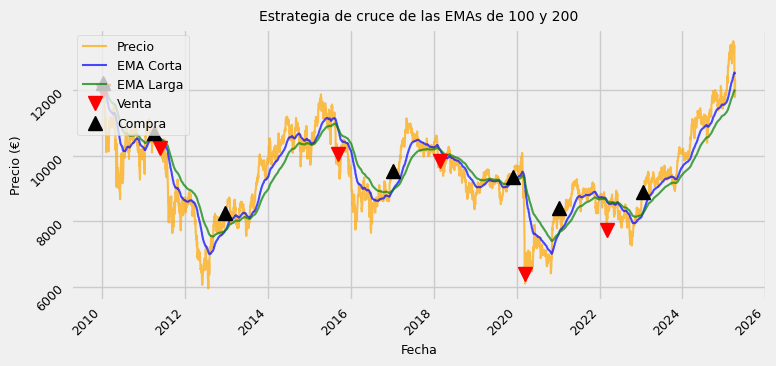

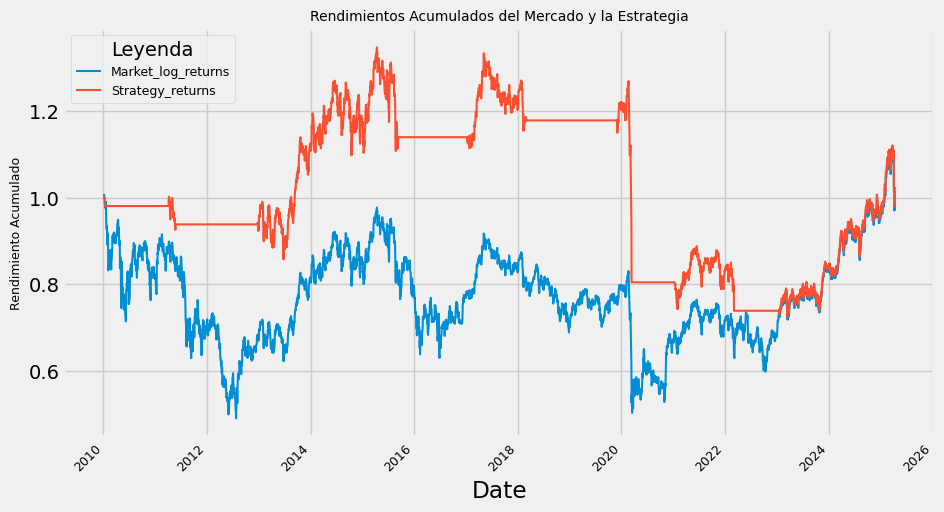

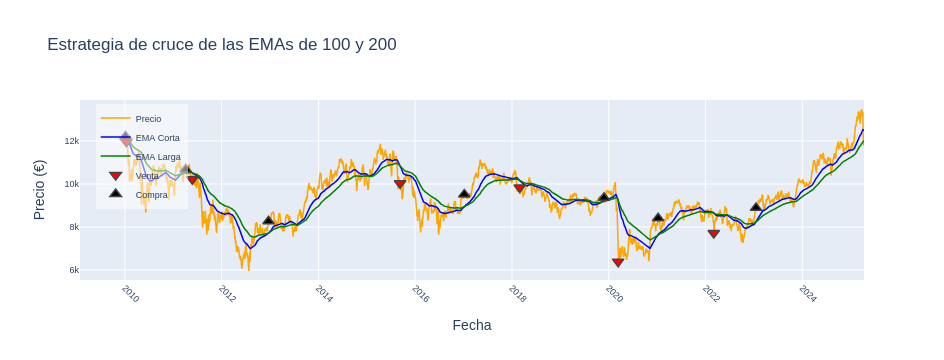

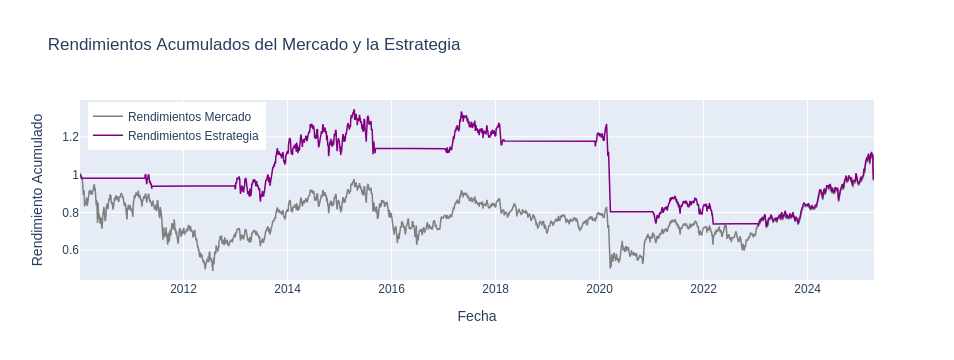


Evolución del capital invertido

Price       Date         Close  Position  Buy_sell_signals  Shares      Remainder  Buy&SellCapital  Buy&HoldCapital
0     2010-01-04  12145.099609       0.0               NaN     0.0  100000.000000    100000.000000     97160.796875
1     2010-01-05  12204.400391       1.0               1.0     8.0    2364.796875    100000.000000     97635.203125
2     2010-01-12  11966.099609       0.0              -1.0     0.0       0.000000     98093.593750     95728.796875
3     2011-04-05  10678.599609       1.0               1.0     9.0    1986.197266     98093.593750     85428.796875
4     2011-05-25  10217.400391       0.0              -1.0     0.0       0.000000     93942.800781     81739.203125
5     2012-12-20   8264.200195       1.0               1.0    11.0    3036.598633     93942.800781     66113.601562
6     2015-09-09  10037.799805       0.0              -1.0     0.0       0.000000    113452.396484     80302.398438
7     2017-01-06   9515.900391       1

In [ ]:
# Ejemplo de uso (asumiendo que el bloque if __name__ == "__main__": de antes existe)
if __name__ == "__main__":
    importador = ImportarCotizaciones()
    all_value_closures, value_closures, all_benchmark_closures, benchmark_close = importador.solicitar_datos()

    ticker = importador.ticker
    benchmark_ticker = importador.benchmark_ticker
    start_date = importador.start_date
    end_date = importador.end_date

    short_period = 100
    long_period = 200
    initial_capital = 100000
    ventana_moda = 20

    # Instanciación y ejecución de la estrategia
    cruce_emas = EMAsStrategy(all_value_closures, value_closures,all_benchmark_closures, benchmark_close,
                 ticker, benchmark_ticker,start_date, end_date, short_period, long_period, initial_capital, ventana_moda)
    cruce_emas.imprimir_advertencia()
    cruce_emas.run_strategy()

    print ('\nEvolución del capital invertido\n')
    print(cruce_emas.capital_evolution[['Date', 'Close', 'Position',  'Buy_sell_signals', 'Shares', 'Remainder', 'Buy&SellCapital', 'Buy&HoldCapital']].to_string())


## Identificación de tendencias
La mejor manera de identificar si estás en una fase de tendencia alcista pronunciada implica una combinación de análisis técnico y fundamental, con un fuerte énfasis en la confirmación a través de múltiples indicadores y marcos de tiempo. Aquí presentamos los enfoques clave:

Análisis Técnico (Identificación de Patrones y Momentum):

    Movimiento del Precio:
        Máximos y Mínimos Crecientes: Esta es la definición fundamental de una tendencia alcista. Observa si cada nuevo máximo es superior al máximo anterior y cada nuevo mínimo es superior al mínimo anterior. En una tendencia pronunciada, estos incrementos suelen ser significativos y sostenidos.
        Velas Alcistas Dominantes: Un predominio de velas verdes (o blancas) grandes y con poco o ningún cuerpo superior sugiere una fuerte presión compradora.
        Rompimiento de Resistencias Clave: La superación con volumen de niveles de resistencia importantes (máximos históricos, líneas de tendencia descendente, medias móviles clave) suele confirmar el inicio o la continuación de una tendencia alcista pronunciada.

    Medias Móviles (MM):
        Alineación Alcista: Las medias móviles de corto, medio y largo plazo deben estar alineadas en orden ascendente (la más corta por encima de la media plazo, y esta por encima de la de largo plazo).
        Pendiente Positiva y Pronunciada: Las medias móviles, especialmente las de medio y largo plazo (ej., 50, 100, 200 períodos), deben tener una pendiente claramente positiva y pronunciada, indicando una aceleración del movimiento alcista.
        El Precio se Mantiene por Encima de las MM Clave: El precio debe operar consistentemente por encima de las medias móviles importantes, utilizando estas como soporte en retrocesos.

    Indicadores de Momentum:
        RSI (Índice de Fuerza Relativa): Valores consistentemente por encima de 50, y a menudo entrando en territorio de sobrecompra (por encima de 70) pero sin generar divergencias bajistas significativas, sugieren un fuerte momentum alcista.
        MACD (Media Móvil de Convergencia/Divergencia): El MACD debe estar por encima de su línea de señal, con el histograma mostrando barras positivas crecientes, indicando un aumento del momentum alcista.
        ADX (Índice Direccional Promedio): Un ADX por encima de 25, y preferiblemente en aumento, indica la fortaleza de la tendencia. Valores por encima de 40 sugieren una tendencia muy fuerte.

    Volumen:
        Volumen Mayor en Movimientos Alcistas: Los días o períodos con movimientos de precio al alza deben estar acompañados de un volumen de negociación mayor que los días o períodos con movimientos a la baja. Esto confirma la convicción detrás de la tendencia.

    Patrones Gráficos Alcistas: La formación y confirmación de patrones como banderas alcistas, banderines alcistas, triángulos ascendentes y canales alcistas pueden indicar la continuación de una tendencia alcista pronunciada.

Análisis Fundamental (Soporte Subyacente):

    Noticias y Datos Económicos Positivos: Un entorno macroeconómico favorable, con datos económicos sólidos (crecimiento del PIB, baja inflación, bajo desempleo), políticas fiscales y monetarias expansivas, y noticias positivas para el sector o la empresa en cuestión, pueden respaldar una tendencia alcista.
    Beneficios Empresariales en Aumento: Para acciones individuales o índices bursátiles, un crecimiento constante y sólido de los beneficios empresariales es un factor fundamental que puede impulsar y sostener una tendencia alcista.
    Sentimiento del Mercado: Un sentimiento generalizado de optimismo y confianza entre los inversores puede alimentar una tendencia alcista. Sin embargo, es importante tener cuidado con el optimismo excesivo, que podría ser una señal de sobrecompra.

Confirmación y Marco de Tiempo:

    Consistencia en Múltiples Marcos de Tiempo: La tendencia alcista debe ser evidente en gráficos de diferentes períodos (diario, semanal, mensual). Una alineación alcista en todos los marcos de tiempo proporciona una confirmación más sólida.
    Duración: Una tendencia alcista pronunciada no suele ser un evento de un solo día. Debe mantenerse durante un período de tiempo significativo para ser considerada como tal.

En resumen, para identificar una fase de tendencia alcista pronunciada, busca:

    Una secuencia clara y sostenida de máximos y mínimos crecientes.
    El precio operando consistentemente por encima de medias móviles clave con pendientes positivas pronunciadas.
    Indicadores de momentum fuertes y en aumento, sin divergencias bajistas significativas.
    Mayor volumen en los movimientos alcistas.
    Patrones gráficos alcistas que se confirman.
    Un entorno fundamental que respalde el movimiento alcista.
    Consistencia de la tendencia en múltiples marcos de tiempo.

La clave es no depender de un solo indicador o señal, sino buscar la confluencia de múltiples factores que apunten en la misma dirección. La paciencia y la observación continua son esenciales para confirmar la fortaleza y la sostenibilidad de una tendencia alcista pronunciada.

# Análisis del IBEX 35: Rangos Temporales Clave para Estrategias de EMA

La gráfica del precio de cierre del IBEX 35 revela distintos períodos con comportamientos de mercado diferenciados, ofreciendo valiosas oportunidades para evaluar la efectividad de estrategias de cruce de medias móviles exponenciales (EMA). A continuación, identificamos y describimos estos rangos clave:

Períodos con Tendencias Definidas:

    Fuerte Tendencia Alcista (aprox. finales de 2002 - finales de 2007): Un período de crecimiento sostenido y marcado, ideal para analizar el comportamiento de la estrategia en un mercado claramente alcista.
    Fuerte Tendencia Bajista (aprox. principios de 2008 - principios de 2009): Una caída pronunciada y rápida tras un máximo, crucial para evaluar la reacción de la estrategia ante un mercado en fuerte declive.
    Recuperación Alcista Post-Crisis (aprox. principios de 2009 - mediados de 2011): Una recuperación notable después de una crisis, que permite observar el desempeño de la estrategia al inicio de una nueva tendencia alcista.
    Tendencia Alcista Reciente (aprox. principios de 2020 - finales de 2024): Un crecimiento significativo en los últimos años, relevante para comprender el rendimiento reciente de la estrategia.

Períodos de Lateralización y Volatilidad:

    Consolidación con Volatilidad (aprox. mediados de 2011 - finales de 2012): Un movimiento lateral con fluctuaciones, importante para analizar la generación de señales en un mercado sin dirección clara.
    Alta Volatilidad sin Tendencia Clara (aprox. principios de 2015 - finales de 2016): Oscilaciones amplias sin una dirección dominante, útil para evaluar la sensibilidad de la estrategia a la volatilidad.
    Nueva Consolidación (aprox. mediados de 2018 - principios de 2020): Un movimiento lateral previo a la última tendencia alcista, similar al primer período de consolidación.

Consideraciones para la Optimización de la Estrategia:

    Tendencias Marcadas: En períodos de tendencias fuertes, se sugiere probar EMAs más lentas (ej., 50, 100, 200 períodos) para enfocarse en la dirección principal y reducir señales falsas.
    Mercados Laterales/Volátiles: En estos rangos, se podría experimentar con EMAs más rápidas (ej., 12, 26 períodos) para capturar movimientos a corto plazo, aunque con el riesgo de aumentar las señales erróneas. También se podría considerar la implementación de filtros adicionales.
    Puntos de Inflexión: Analizar el comportamiento de la estrategia en torno a máximos y mínimos significativos puede ofrecer información valiosa sobre su capacidad para identificar cambios de tendencia.

Análisis Adicional:

Subdividir los períodos de tendencia fuerte podría revelar variaciones en el comportamiento de la estrategia en las diferentes etapas de la tendencia.

Evaluar la estrategia en estos diversos rangos temporales proporcionará una comprensión más profunda de su robustez y adaptabilidad a las distintas condiciones del mercado del IBEX 35. Si bien el rendimiento pasado no garantiza resultados futuros, este análisis histórico es fundamental para el desarrollo y la optimización de estrategias de trading.

Contexto de las Crisis Mencionadas:

    Crisis Financiera 2008-2009: Un shock global originado por el colapso del mercado inmobiliario estadounidense, que generó una profunda crisis de confianza e iliquidez.
    Recuperación Post-Crisis (2009-2011): Una fase de reactivación impulsada por intervenciones gubernamentales y de bancos centrales a través de estímulos y bajas tasas de interés.
    Crisis COVID-19 (2020): Un impacto económico sin precedentes debido a confinamientos y disrupciones en las cadenas de suministro, seguido de una recuperación por estímulos y expectativas de mejora económica.

En esencia, las caídas abruptas fueron resultado de eventos económicos y financieros inesperados que sembraron miedo e incertidumbre, mientras que las recuperaciones se sustentaron en medidas políticas y económicas para restaurar la confianza y estimular el crecimiento.

Análisis de la Tendencia 2010-2019:

El período 2010-2019 para el IBEX 35 se caracterizó por una lateralización con volatilidad, sin una tendencia alcista o bajista dominante y sostenida.

    2010-2011: Recuperación Volátil: Un intento inicial de recuperación tras la crisis, marcado por la crisis de deuda soberana europea y la consiguiente volatilidad.
    2012-2016: Lateralización Amplia: El índice se movió dentro de un rango extenso sin una dirección clara a largo plazo, con fluctuaciones influenciadas por factores económicos y políticos.
    2017: Intento Alcista Fallido: Un breve período de impulso alcista que no logró consolidarse y fue seguido por una corrección.
    2018-2019: Lateralización con Sesgo Bajista: Un retorno a la negociación lateral, pero con una ligera presión bajista debido a preocupaciones económicas globales y tensiones comerciales.

En comparación con la tendencia alcista previa a 2008 o la recuperación posterior a 2020, la década de 2010 fue un período de indecisión y consolidación para el IBEX 35. Al aplicar estrategias de cruce de EMAs en este contexto, es crucial considerar la mayor probabilidad de señales falsas debido a la falta de tendencias claras. El uso de filtros adicionales o la adaptación de los parámetros de las EMAs podría ser necesario para mejorar la efectividad de la estrategia.

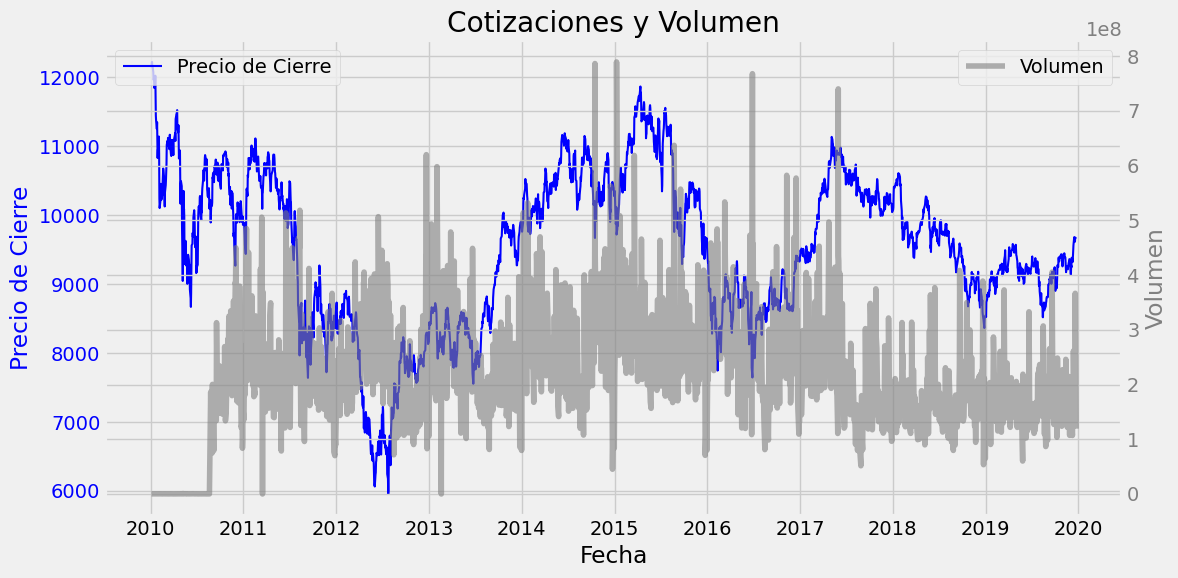

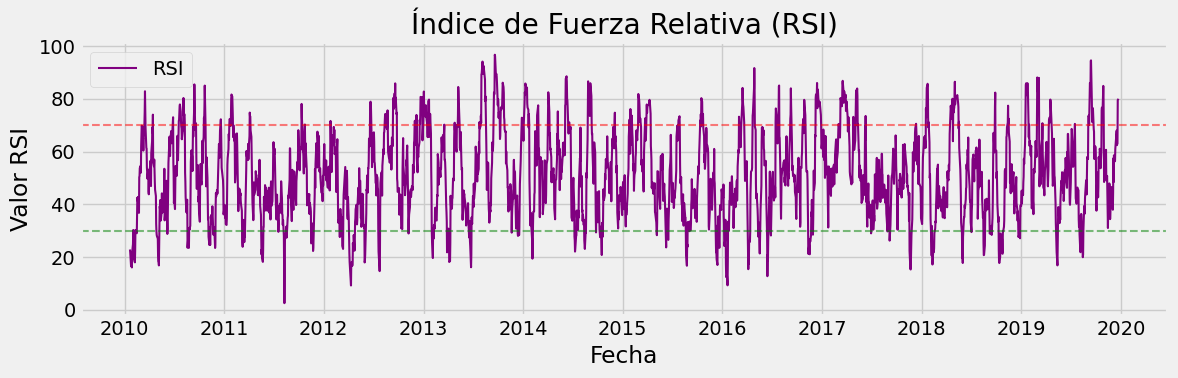

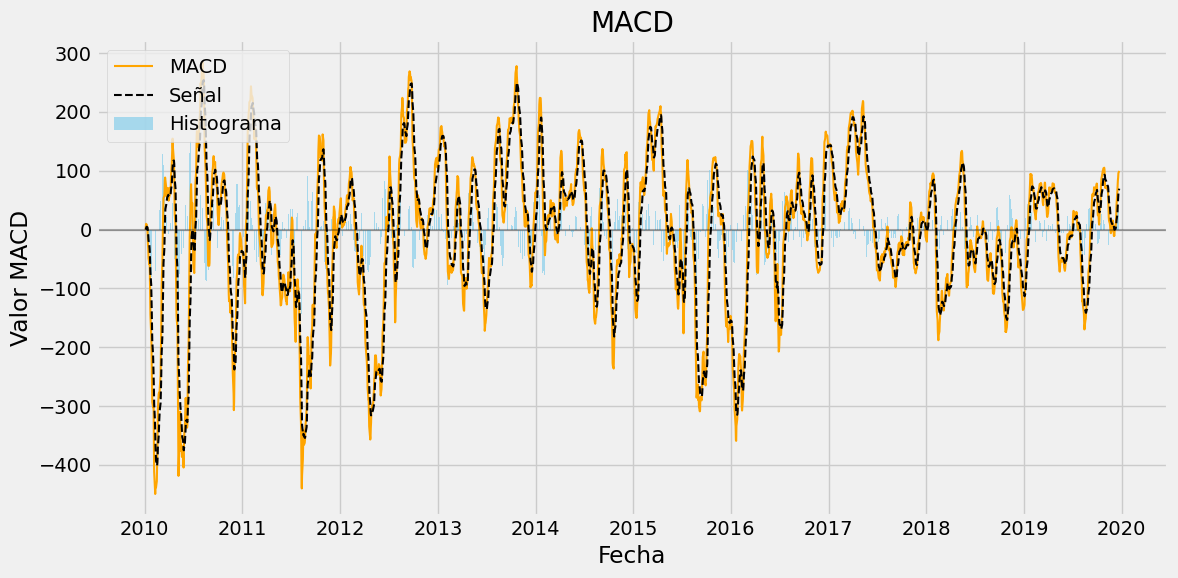

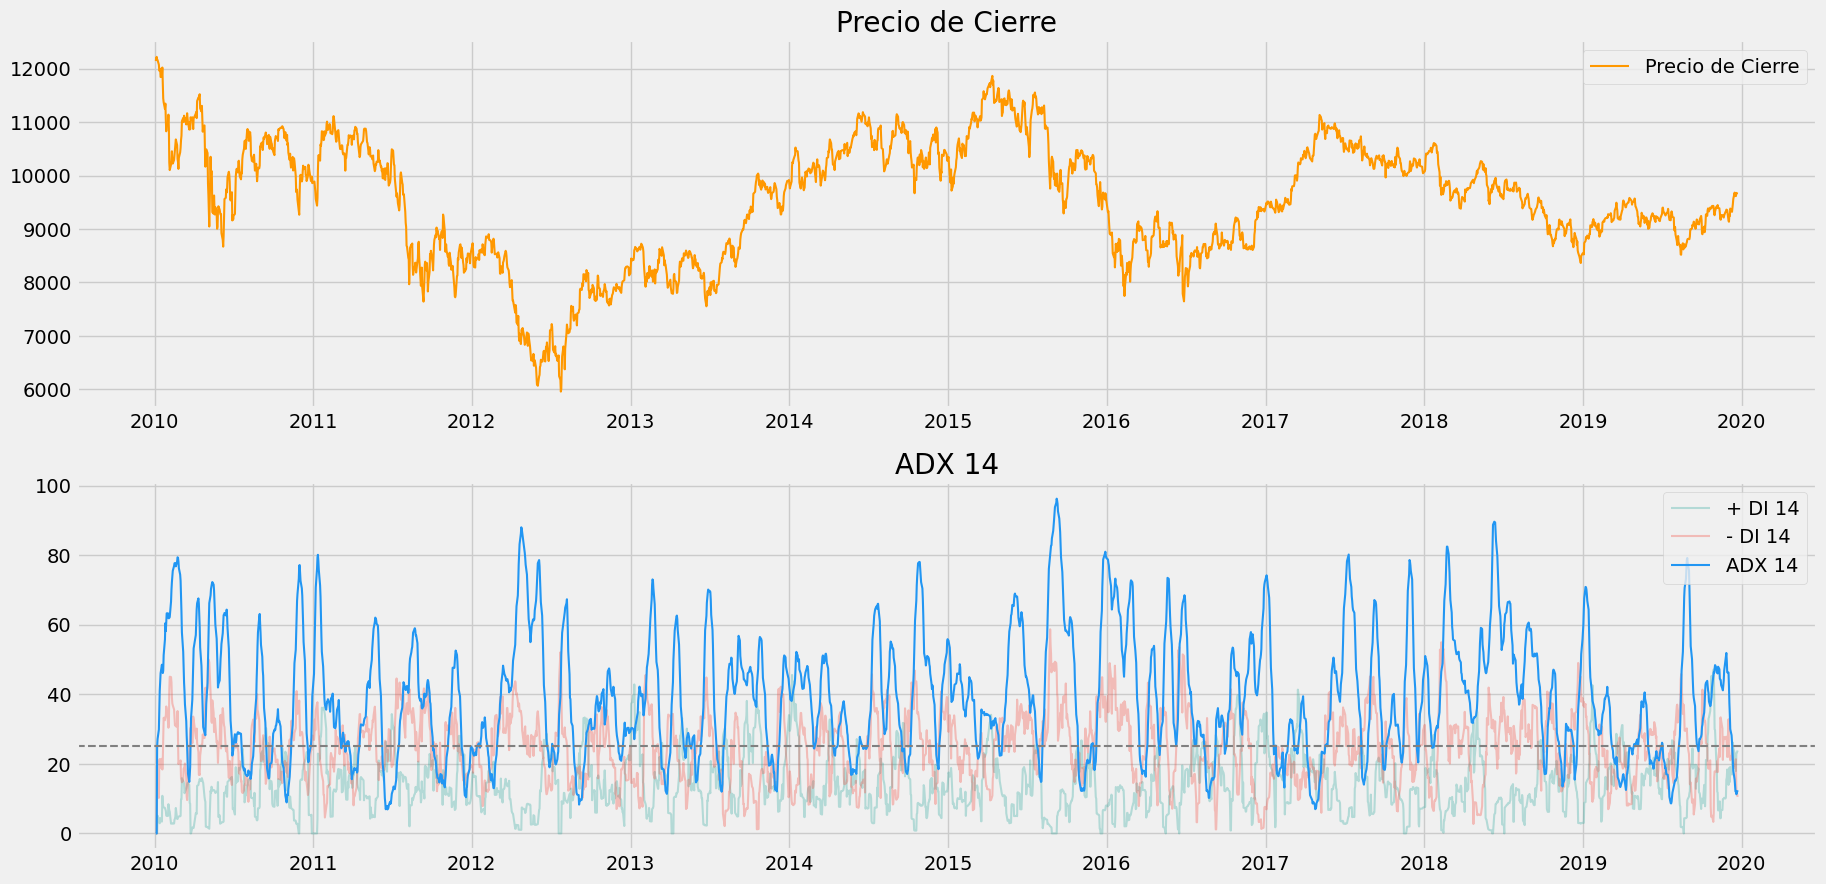


Diagnóstico de la tendencia: Posible inicio de tendencia alcista (ADX débil)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

class TechnicalIndicatorQueue:
    def __init__(self, dataframe: pd.DataFrame, window_rsi: int = 14, window_macd_fast: int = 12,
                 window_macd_slow: int = 26, window_macd_signal: int = 9, window_adx: int = 14):
        """
        Inicializa la clase TechnicalIndicatorQueue.

        Args:
            dataframe (pd.DataFrame): DataFrame con datos de precios ('Close', 'High', 'Low', 'Volume').
            window_rsi (int): Ventana para el cálculo del RSI.
            window_macd_fast (int): Ventana rápida para el cálculo del MACD.
            window_macd_slow (int): Ventana lenta para el cálculo del MACD.
            window_macd_signal (int): Ventana para la línea de señal del MACD.
            window_adx (int): Ventana para el cálculo del ADX.
        """
        self.df = dataframe.copy()
        self.window_rsi = window_rsi
        self.window_macd_fast = window_macd_fast
        self.window_macd_slow = window_macd_slow
        self.window_macd_signal = window_macd_signal
        self.window_adx = window_adx
        self._calculate_rsi()
        self._calculate_macd()
        self._calculate_adx()

    def _calculate_rsi(self):
        """Calcula el Índice de Fuerza Relativa (RSI) utilizando pandas."""
        delta = self.df['Close'].diff(1)
        gain = (delta.where(delta > 0, 0)).rolling(window=self.window_rsi).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=self.window_rsi).mean()

        rs = gain / loss
        self.df['RSI'] = 100 - (100 / (1 + rs))

    def _calculate_macd(self):
        """Calcula la Media Móvil de Convergencia/Divergencia (MACD) utilizando pandas."""
        ema_fast = self.df['Close'].ewm(span=self.window_macd_fast, adjust=False).mean()
        ema_slow = self.df['Close'].ewm(span=self.window_macd_slow, adjust=False).mean()
        self.df['MACD'] = ema_fast - ema_slow
        self.df['Signal'] = self.df['MACD'].ewm(span=self.window_macd_signal, adjust=False).mean()
        self.df['Histogram'] = self.df['MACD'] - self.df['Signal']

    def _calculate_adx_0(self, lookback=None):
        """Calcula el Índice Direccional Promedio (ADX) utilizando pandas."""
        if lookback is None:
            lookback = self.window_adx

        high = self.df['High']
        low = self.df['Low']
        close = self.df['Close']

        plus_dm = high.diff()
        minus_dm = low.diff()
        plus_dm[plus_dm < 0] = 0
        minus_dm[minus_dm > 0] = 0

        tr1 = high - low
        tr2 = abs(high - close.shift(1))
        tr3 = abs(low - close.shift(1))
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

        atr = tr.rolling(lookback).mean()
        plus_di = 100 * (plus_dm.ewm(alpha=1/lookback).mean() / atr)
        minus_di = 100 * (minus_dm.ewm(alpha=1/lookback).mean() / atr)
        dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
        adx = dx.rolling(lookback).mean()

        # Guardar los resultados en el DataFrame
        self.df['plus_di'] = plus_di
        self.df['minus_di'] = minus_di
        self.df['ADX'] = adx
        self.df['PDI'] = plus_di # Adding PDI for trend diagnosis
        self.df['NDI'] = minus_di # Adding NDI for trend diagnosis

    def _calculate_adx(self, lookback=None):
        """Calcula el Índice Direccional Promedio (ADX) utilizando pandas."""
        if lookback is None:
            lookback = self.window_adx

        high = self.df['High']
        low = self.df['Low']
        close = self.df['Close']

        # 1. Calcular los movimientos direccionales (+DM y -DM)
        plus_dm = pd.Series(np.where((high.diff() > 0) & (high.diff() > abs(low.diff())), high.diff(), 0), index=self.df.index)
        minus_dm = pd.Series(np.where((low.diff() < 0) & (abs(low.diff()) > high.diff()), abs(low.diff()), 0), index=self.df.index)

        # 2. Calcular el Rango Verdadero (TR)
        tr1 = high - low
        tr2 = abs(high - close.shift(1).fillna(close.iloc[0]))
        tr3 = abs(low - close.shift(1).fillna(close.iloc[0]))
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

        # 3. Suavizar +DM, -DM y TR usando una media móvil simple
        plus_dm_smoothed = plus_dm.rolling(window=lookback, min_periods=1).sum()
        minus_dm_smoothed = minus_dm.rolling(window=lookback, min_periods=1).sum()
        tr_smoothed = tr.rolling(window=lookback, min_periods=1).sum()

        # 4. Calcular los Indicadores Direccionales (+DI y -DI)
        plus_di = 100 * (plus_dm_smoothed / tr_smoothed)
        minus_di = 100 * (minus_dm_smoothed / tr_smoothed)

        # 5. Calcular el Índice Direccional (DX)
        dx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di))
        dx = dx.fillna(0)  # Manejar divisiones por cero

        # 6. Calcular el Índice Direccional Promedio (ADX)
        adx = dx.rolling(window=lookback, min_periods=1).mean()

        # Guardar los resultados en el DataFrame
        self.df['plus_di_alt'] = plus_di
        self.df['minus_di_alt'] = minus_di
        self.df['ADX_alt'] = adx
        self.df['PDI_alt'] = plus_di # Adding PDI for trend diagnosis
        self.df['NDI_alt'] = minus_di # Adding NDI for trend diagnosis

        return self.df

    def plot_data(self):
        """Muestra gráficas de cotizaciones, volumen, RSI, MACD y ADX en ventanas separadas."""
        fig, ax1 = plt.subplots(figsize=(12, 6))

        color = 'blue'
        ax1.set_xlabel('Fecha')
        ax1.set_ylabel('Precio de Cierre', color=color)
        ax1.plot(self.df.index, self.df['Close'], label='Precio de Cierre', color=color, lw=1.5)
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.legend(loc='upper left')
        ax1.grid(True)

        ax2 = ax1.twinx()  # Crea el segundo eje Y compartido

        color = 'grey'
        ax2.set_ylabel('Volumen', color=color)
        ax2.plot(self.df.index, self.df['Volume'], label='Volumen', color=color, alpha=0.6)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.legend(loc='upper right')

        plt.title('Cotizaciones y Volumen')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(12, 4))
        plt.plot(self.df.index, self.df['RSI'], label='RSI', color='purple', lw=1.5)
        plt.axhline(70, color='r', linestyle='--', alpha=0.5, lw=1.5)
        plt.axhline(30, color='g', linestyle='--', alpha=0.5, lw=1.5)
        plt.title('Índice de Fuerza Relativa (RSI)')
        plt.xlabel('Fecha')
        plt.ylabel('Valor RSI')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(self.df.index, self.df['MACD'], label='MACD', color='orange', lw=1.5)
        plt.plot(self.df.index, self.df['Signal'], label='Señal', color='black', linestyle='--', lw=1.5)
        plt.bar(self.df.index, self.df['Histogram'], label='Histograma', color='skyblue', alpha=0.7)
        plt.axhline(0, color='black', linestyle='-', alpha=0.3, lw=1.5)
        plt.title('MACD')
        plt.xlabel('Fecha')
        plt.ylabel('Valor MACD')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Asegurar que las columnas existen antes de graficar
        required_cols = ['plus_di_alt', 'minus_di_alt', 'ADX_alt', 'Close']
        for col in required_cols:
            if col not in self.df.columns:
                print(f"Error: La columna '{col}' no existe en el DataFrame.")
                return

        fig, ax = plt.subplots(2, 1, figsize=(20, 10))

        ax[0].plot(self.df['Close'], color='#ff9800', label="Precio de Cierre", lw=1.5)
        ax[0].set_title('Precio de Cierre')
        ax[0].legend()

        ax[1].plot(self.df['plus_di_alt'], color='#26a69a', label='+ DI {}'.format(self.window_adx), linewidth=1.5, alpha=0.3)
        ax[1].plot(self.df['minus_di_alt'], color='#f44336', label='- DI {}'.format(self.window_adx), linewidth=1.5, alpha=0.3)
        ax[1].plot(self.df['ADX_alt'], color='#2196f3', label='ADX {}'.format(self.window_adx), linewidth=1.5)
        ax[1].axhline(25, color='grey', lw=1.5, linestyle='--')
        ax[1].legend()
        ax[1].set_title('ADX {}'.format(self.window_adx))

        plt.show()

    def diagnose_trend(self) -> str:
        """
        Diagnostica el tipo de tendencia basándose en los indicadores técnicos.

        Returns:
            str: El tipo de tendencia diagnosticada.
        """
        if self.df.empty:
            return "No hay datos para diagnosticar la tendencia."

        last_rsi = self.df['RSI'].iloc[-1]
        last_macd = self.df['MACD'].iloc[-1]
        last_signal = self.df['Signal'].iloc[-1]
        last_histogram = self.df['Histogram'].iloc[-1]
        last_adx = self.df['ADX_alt'].iloc[-1] # Use the '_alt' version
        last_pdi = self.df['plus_di_alt'].iloc[-1] # Use the '_alt' version
        last_ndi = self.df['minus_di_alt'].iloc[-1] # Use the '_alt' version

        if last_adx > 25:
            if last_pdi > last_ndi:
                if last_rsi > 50 and last_macd > last_signal and last_histogram > 0:
                    return "Fuerte tendencia alcista"
                elif last_rsi > 50 or last_macd > last_signal:
                    return "Tendencia alcista"
                else:
                    return "Posible inicio de tendencia alcista o consolidación con sesgo alcista"
            elif last_ndi > last_pdi:
                return "Tendencia bajista (ADX fuerte)"
            else:
                return "Posible inicio de tendencia o consolidación (ADX fuerte)"
        else:
            if abs(last_pdi - last_ndi) < 5:
                return "Rango o consolidación (ADX débil)"
            elif last_pdi > last_ndi and last_rsi > 50 and last_macd > last_signal:
                return "Posible inicio de tendencia alcista (ADX débil)"
            elif last_ndi > last_pdi and last_rsi < 50 and last_macd < last_signal:
                return "Posible inicio de tendencia bajista (ADX débil)"
            else:
                return "Indefinido o consolidación (ADX débil)"


# Ejemplo de cómo crear un DataFrame de prueba si 'cruce_emas' no está definido

data = cruce_emas.all_value_closures.copy()

# Crear una instancia de la clase y realizar los cálculos y visualizaciones
technical_queue = TechnicalIndicatorQueue(data['2010-01-04':'2019-12-23'].copy())
technical_queue.plot_data()
trend_diagnosis = technical_queue.diagnose_trend()
print(f"\nDiagnóstico de la tendencia: {trend_diagnosis}")

# Nota de advertencias.
<font color='blue'>
Este note book se proporciona únicamente con fines educativos e informativos. No se debe considerar asesoramiento legal o financiero. No se ofrece ninguna garantía u otra promesa en cuanto a los resultados que se pueden obtener al usar su contenido.
    
En la medida máxima permitida por la ley, se nos exime de toda responsabilidad en caso de que cualquier información, comentario, análisis, opinión, consejo y / o recomendación se muestre inexacta, incompleta o poco confiable, o resulte en una inversión u otra pérdida. Se advierte que el rendimiento pasado no es un indicador confiable de resultados futuros.
    
Recuerde que ninguna estrategia de trading es infalible, y siempre existe un riesgo asociado al operar en los mercados financieros. Es esencial gestionar adecuadamente el riesgo y utilizar la estrategia junto con una gestión de capital adecuada. Además, es recomendable consultar con profesionales financieros o analistas antes de tomar decisiones de trading importantes.
    </font>